In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter
from functools import reduce

import sys
sys.path.append("..")
from data_preparation.data_preparation_pos import read_conll
import utils.utils as utils
import utils.pos_utils as pos_utils

In [319]:
def top_n(info, table, n):
    filepath = info["file_path"]
    lang_name = info["lang_name"]
    dataset = info["dataset"]
    conll_data = read_conll(filepath)
    tags = np.array(conll_data[2]).flatten().sum()
    df = pd.DataFrame(list(Counter(tags).items()), columns=["Tag", "Count"])
    df = df.sort_values("Count", ascending=False).reset_index(drop=True)
    df["Count(%)"] = df["Count"] / df["Count"].sum() * 100
    df["Cumulative(%)"] = df["Count(%)"].cumsum()
    top = " ".join(df["Tag"].values[:n])
    table.update(pd.DataFrame({"Top": [top]}, 
                              index=table.index[(table["Language"] == lang_name) & (table["Dataset"] == dataset)]))
    return table

In [90]:
def multi_merge(left, right, r):
    left_cols = ["Tag"] + list(filter(r.match, left.columns))
    right_cols = ["Tag"] + list(filter(r.match, right.columns))
    return pd.merge(left[left_cols], right[right_cols], on="Tag", suffixes=(None, "_{}".format(len(left_cols)-1)))

In [50]:
def calculate_total_tag_table(dfs):
    total = reduce(lambda left, right: multi_merge(left, right, re.compile("^Count($|_)")), dfs)
    total["Count"] = total.iloc[:,1:].apply(np.sum, axis=1)
    total = total.sort_values("Count", ascending=False).reset_index(drop=True)
    total = total.loc[:, ["Tag", "Count"]]
    total["Count(%)"] = total["Count"] / total["Count"].sum() * 100
    total["Cumulative(%)"] = total["Count(%)"].cumsum()
    
    return total

In [4]:
def tag_freq(info, output, lang_to_group):
    lang_name = info["lang_name"]
    file_path = info["file_path"]
    dataset = info["dataset"]
    group = lang_to_group[lang_name]
    
    conll_data = read_conll(file_path)
    tags = np.array(conll_data[2]).flatten().sum()
    df = pd.DataFrame(list(Counter(tags).items()), columns=["Tag", "Count"])
    df = df.sort_values("Count", ascending=False).reset_index(drop=True)
    df["Count(%)"] = df["Count"] / df["Count"].sum() * 100
    df["Cumulative(%)"] = df["Count(%)"].cumsum()
    
    # Add missing tags
    tagset = pos_utils.get_ud_tags()
    missing_tags = set(tagset) ^ set(df["Tag"])
    missing_data = {col: [100]*len(missing_tags) if "Cumulative" in col else [0]*len(missing_tags) for col in df.columns[1:]}
    missing_rows = pd.DataFrame({"Tag": list(missing_tags), **missing_data},
                                index=range(df.shape[0], df.shape[0] + len(missing_tags)))
    df = pd.concat([df, missing_rows])
    
    if lang_name not in output[group].keys():
        output[group][lang_name] = {}
    output[group][lang_name][dataset] = df
    
    # Calculate totals if all datasets are done
    if len(output[group][lang_name].keys()) == 3:
        total = calculate_total_tag_table(output[group][lang_name].values())
        output[group][lang_name]["total"] = total
    
    return output

In [5]:
tag_tables = utils.run_through_data("../data/ud/", tag_freq, lang_to_group=utils.make_lang_group_dict(),
                                    table={x: {} for x in ["Fusional", "Isolating", "Agglutinative", "Introflexive"]})

In [105]:
def calculate_group_avg_tables(group_tables):
    group_avgs = {}
    
    for dataset in ["train", "dev", "test", "total"]:
        table = reduce(lambda left, right: multi_merge(left, right, re.compile("^Count\(%\)")), 
                       [group_tables[lang][dataset] for lang in group_tables.keys() if dataset in group_tables[lang].keys()])
        table = pd.DataFrame({"Tag": table["Tag"],
                              "MeanCount(%)": table.iloc[:,1:].apply(np.mean, axis=1)})
        table = table.sort_values("MeanCount(%)", ascending=False).reset_index(drop=True)
        table["Cumulative(%)"] = table["MeanCount(%)"].cumsum()
        group_avgs[dataset] = table
        
    return group_avgs

In [109]:
group_to_color = {
    "Fusional": "#95c78f",
    "Isolating": "#f79d97",
    "Agglutinative": "#abaff5",
    "Introflexive": "#fffecc"
}

In [113]:
for group in tag_tables.keys():
    writer = pd.ExcelWriter("tag_stats/tag_stats_{}.xlsx".format(group.lower()))
    workbook  = writer.book
    
    # Formats
    percentage_format = workbook.add_format({"num_format": "0.00\%"})
    merge_format = workbook.add_format({
        "bold": 1,
        "border": 1,
        "align": "center",
        "fg_color": group_to_color[group],
        "font_size": 16
    })
    
    # Sheet for every language
    langs = utils.order_table(pd.DataFrame(tag_tables[group].keys(), columns=["Language"])).iloc[:,0].values # Order as usual
    
    for lang in langs:
        if len(tag_tables[group][lang].keys()) > 1:
            for i, dataset in enumerate(["train", "dev", "test", "total"]):
                dcol = tag_tables[group][lang][dataset].shape[1] + 1
                tag_tables[group][lang][dataset].to_excel(writer, index=False, sheet_name=lang, 
                                                          startcol=i * dcol, startrow=1)
                worksheet = writer.sheets[lang]
                worksheet.merge_range(0, i * dcol, 0, (i + 1) * dcol - 2, dataset.upper(), merge_format)
                worksheet.set_column((i * dcol) + 2, (i * dcol) + 3, 15, percentage_format)
        else:
            i = 0
            dataset = list(tag_tables[group][lang].keys())[0]
            dcol = tag_tables[group][lang][dataset].shape[1] + 1
            tag_tables[group][lang][dataset].to_excel(writer, index=False, sheet_name=lang, startrow=1)
            worksheet = writer.sheets[lang]
            worksheet.merge_range(0, i * dcol, 0, (i + 1) * dcol - 2, dataset.upper(), merge_format)
            worksheet.set_column((i * dcol) + 2, (i * dcol) + 3, 15, percentage_format)
            
    # Group average sheet
    group_avgs = calculate_group_avg_tables(tag_tables[group])
    
    for i, dataset in enumerate(["train", "dev", "test", "total"]):
        dcol = group_avgs[dataset].shape[1] + 1
        group_avgs[dataset].to_excel(writer, index=False, sheet_name=group, 
                                     startcol=i * dcol, startrow=1)
        worksheet = writer.sheets[group]
        worksheet.merge_range(0, i * dcol, 0, (i + 1) * dcol - 2, dataset.upper(), merge_format)
        worksheet.set_column((i * dcol) + 1, (i * dcol) + 2, 15, percentage_format)
        
    worksheet.set_tab_color(group_to_color[group]) # Special color for group sheet
            
    writer.close()

In [81]:
utils.order_table(pd.DataFrame({"Language": ["Croatian", "Bulgarian"]}))

,Language
0,Bulgarian
1,Croatian


<Figure size 1008x432 with 0 Axes>

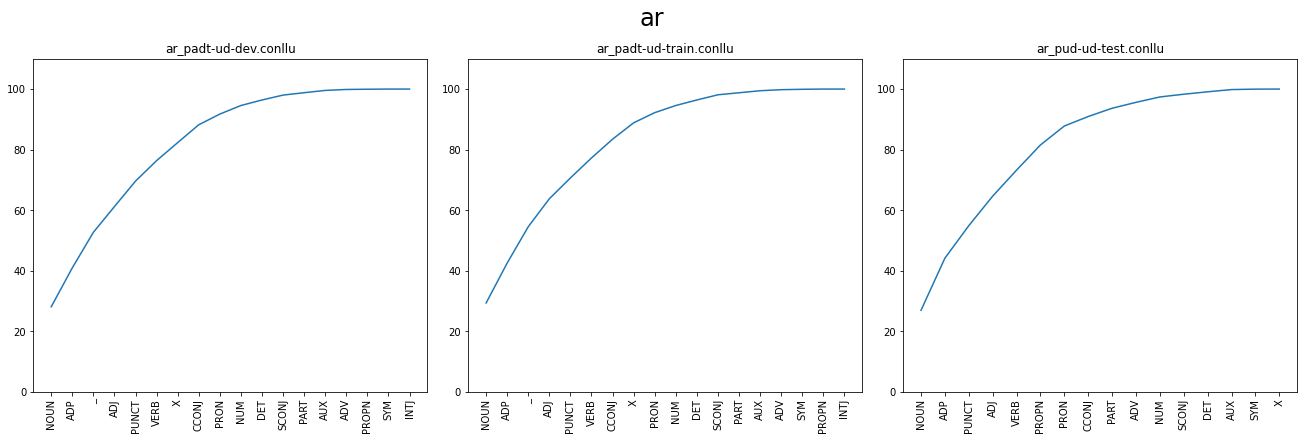

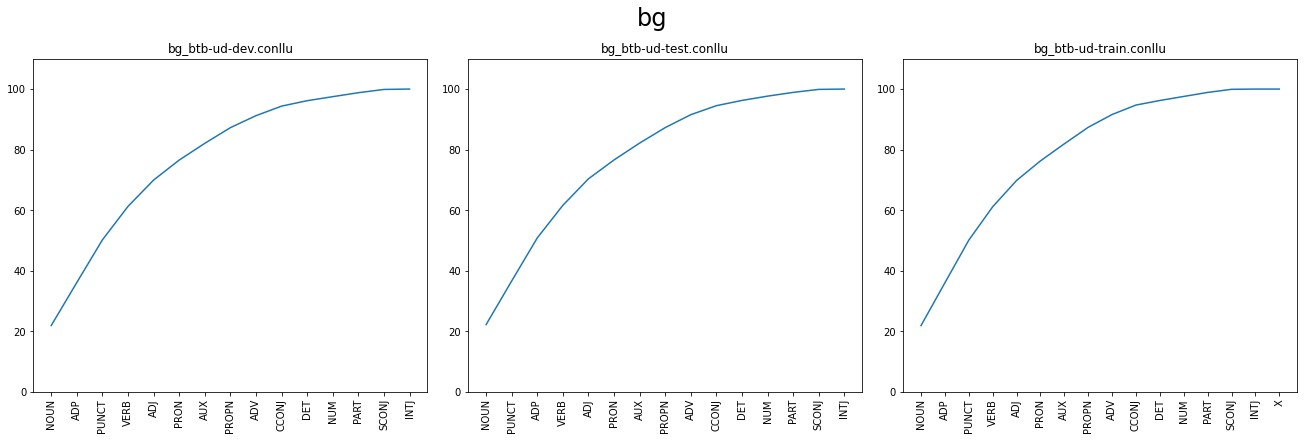

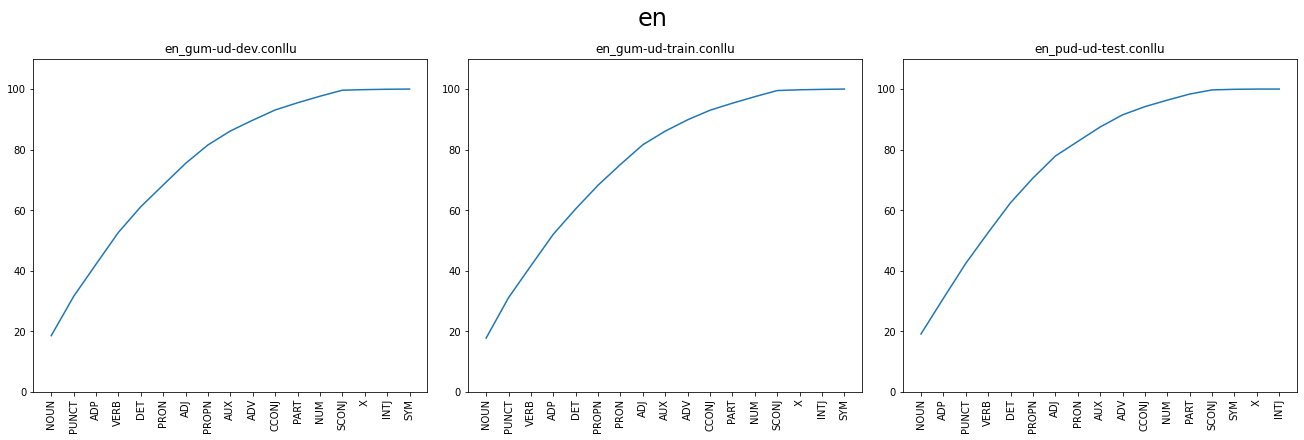

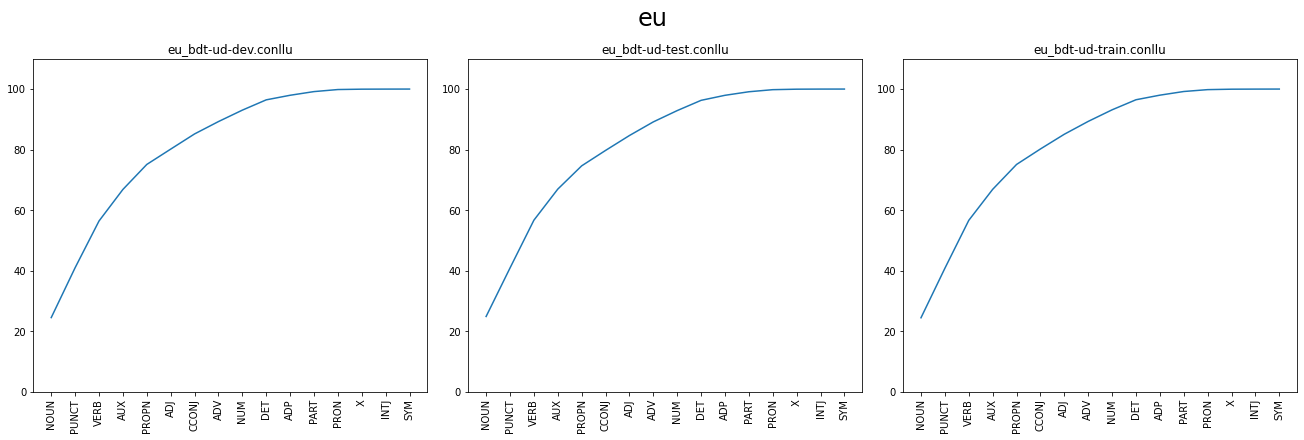

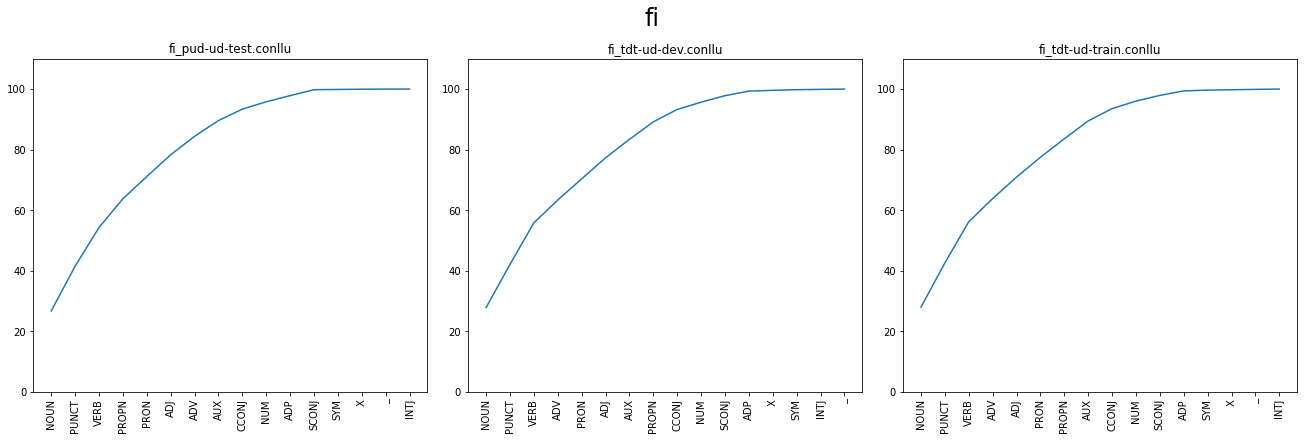

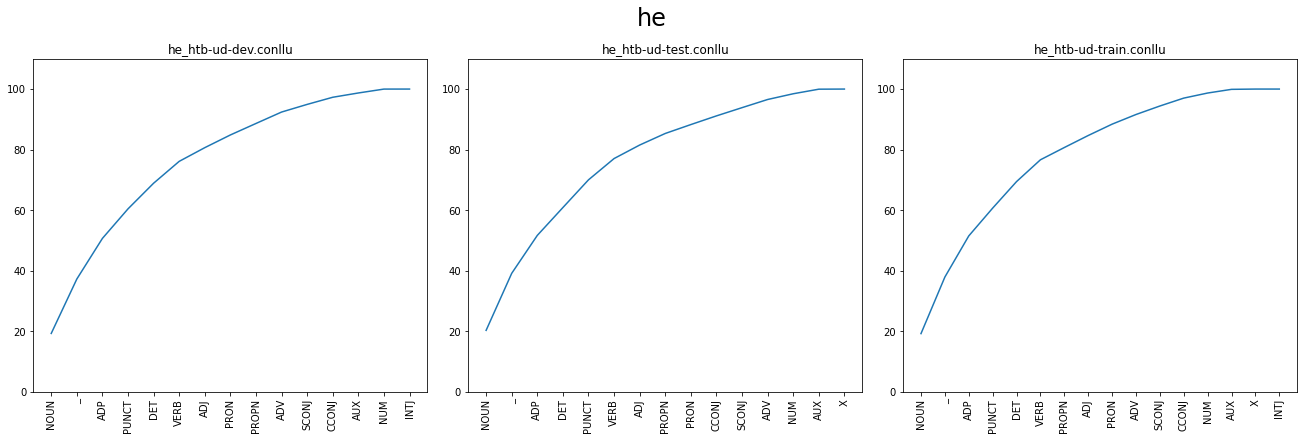

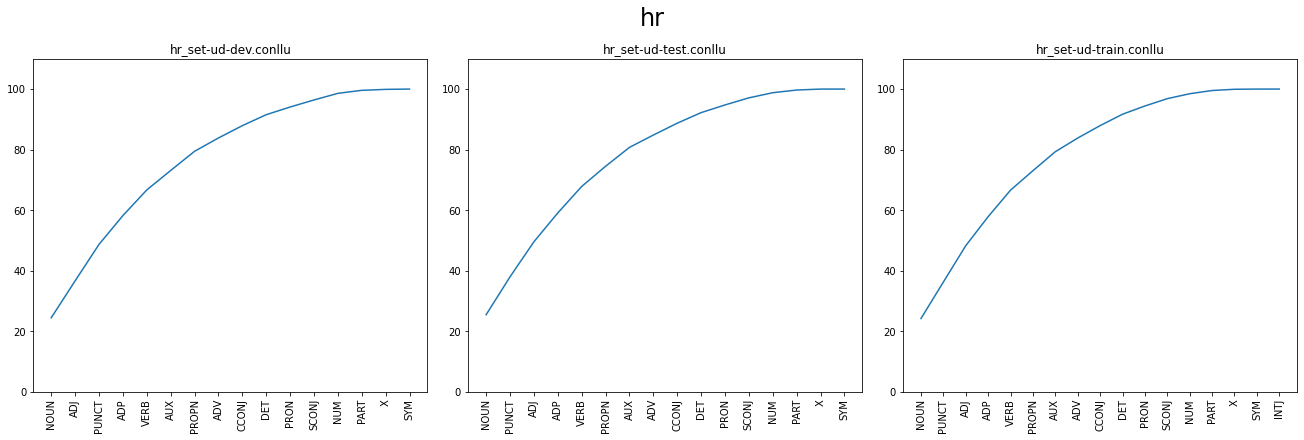

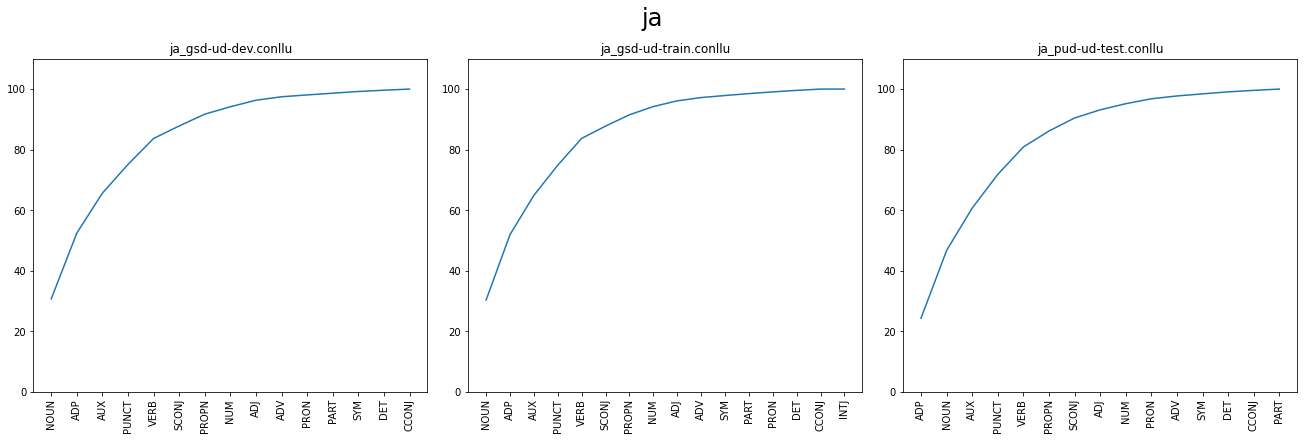

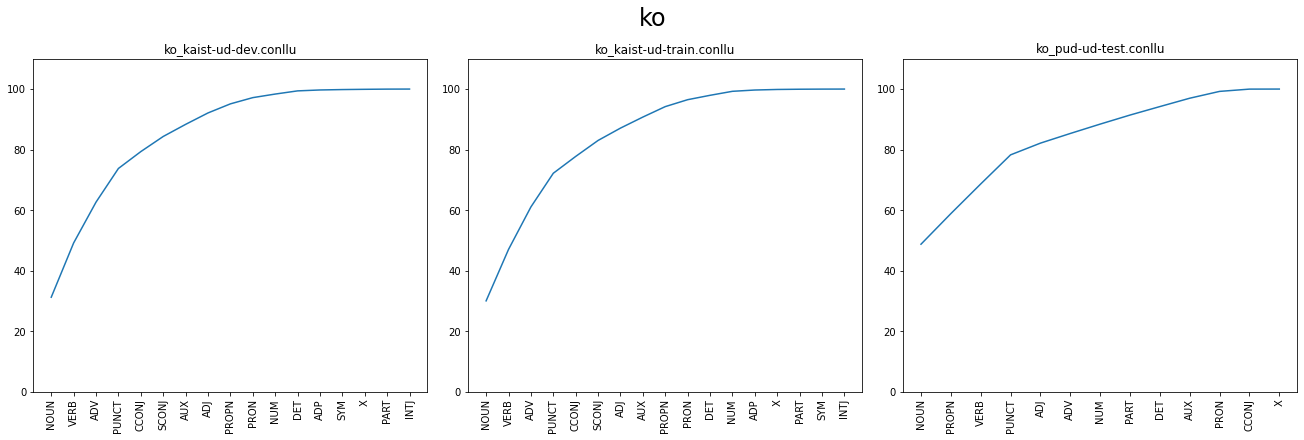

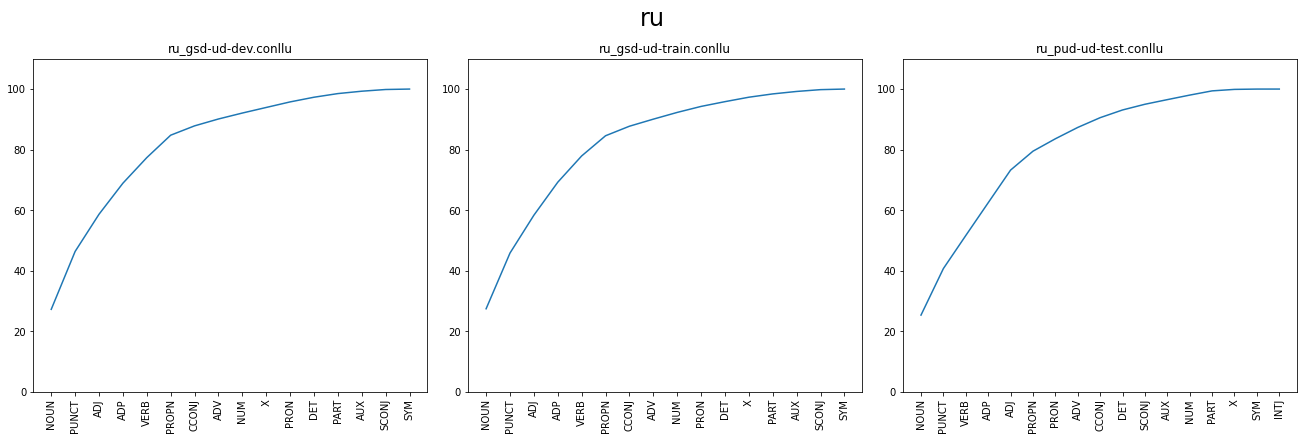

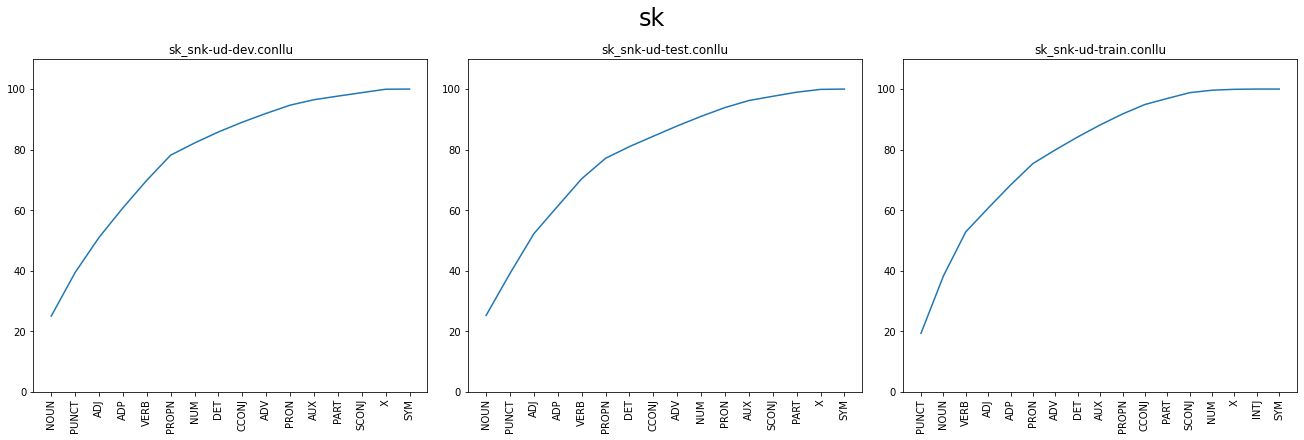

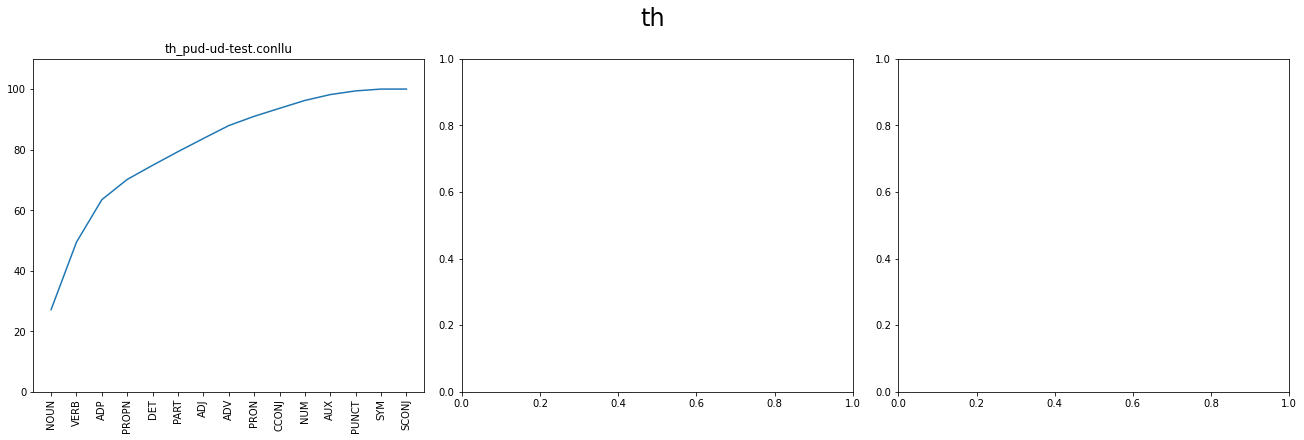

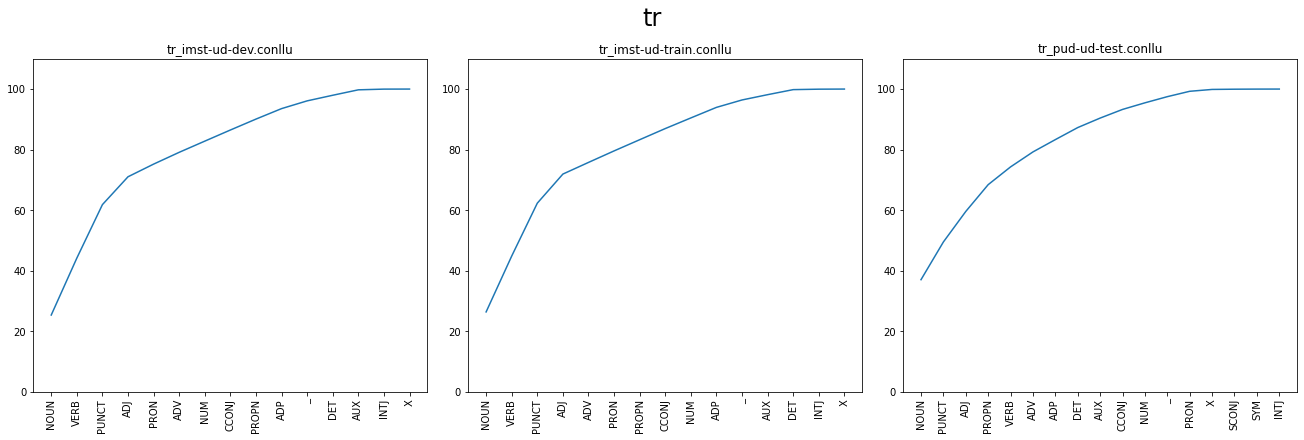

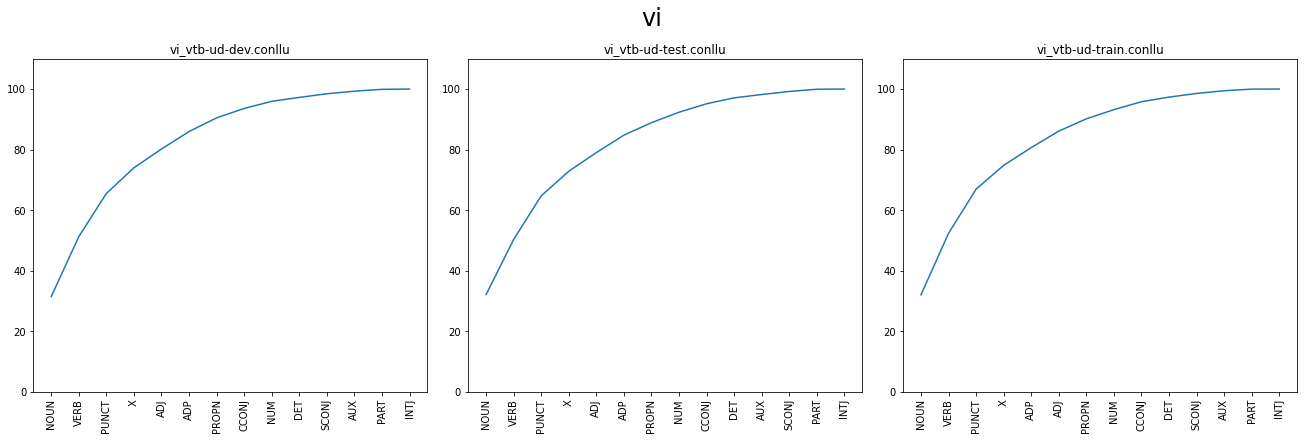

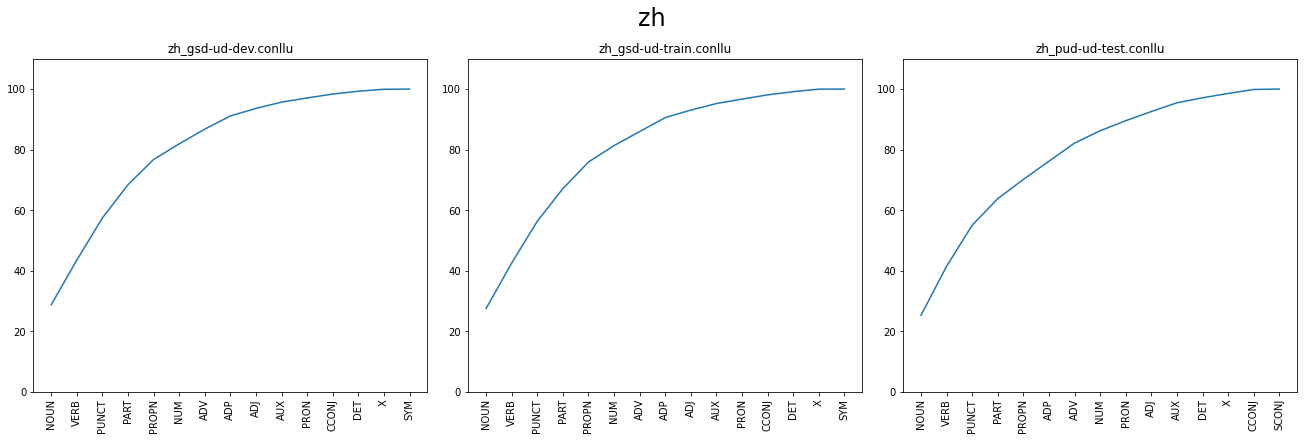

In [106]:
files = glob.glob("../data/ud/*/*.conllu")

for filepath in tqdm(files):
    lang = filepath.split("\\")[-2]
    
    conll_data = read_conll(filepath)
    tags = np.array(conll_data[2]).flatten().sum()
    df = pd.DataFrame(list(Counter(tags).items()), columns=["Tag", "Count"])
    df = df.sort_values("Count", ascending=False).reset_index(drop=True)
    df["Count(%)"] = df["Count"] / df["Count"].sum() * 100
    df["Cumulative(%)"] = df["Count(%)"].cumsum()

In [40]:
p1 = [25, 16, 13, 9, 6]
p2 = [24, 17, 10, 9, 7]
p3 = [26, 16, 0, 8, 12]

df_plot = pd.DataFrame({"Tag": ["NOUN", "ADP", "MULTI", "ADJ", "PUNCT", "OTHERS"],
              "Train": p1 + [100 - sum(p1)],
              "Dev": p2 + [100 - sum(p2)],
              "Test": p3 + [100 - sum(p3)]})

In [41]:
sns.set()
sns.set_style("ticks")

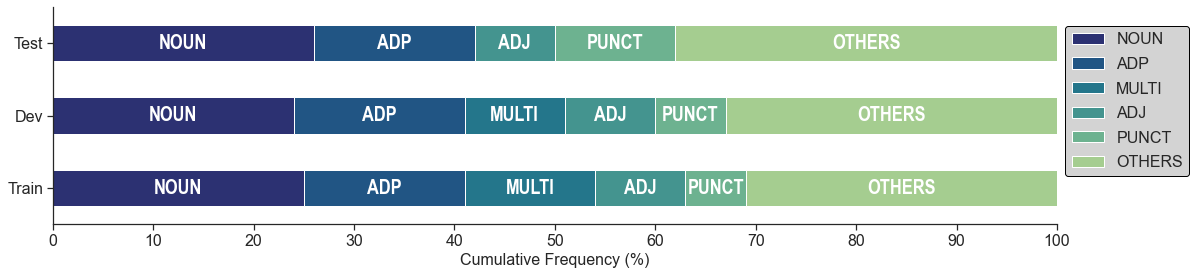

In [42]:
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s=row["Tag"], color="white", fontsize=20, fontstretch="condensed",
                   horizontalalignment="center", verticalalignment="center", fontweight="bold")
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(1, 0.95), fontsize=16, facecolor="lightgrey", 
         framealpha=1, edgecolor="black", labelspacing=0.6)
sns.despine(ax=g)

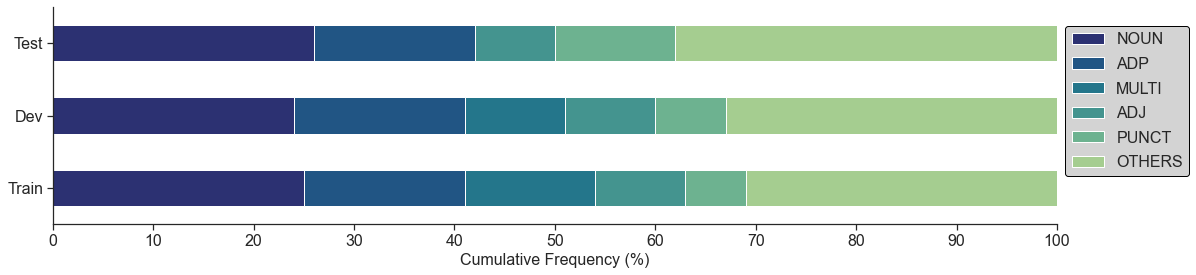

In [43]:
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(1, 0.95), fontsize=16, facecolor="lightgrey", 
         framealpha=1, edgecolor="black", labelspacing=0.6)
sns.despine(ax=g)

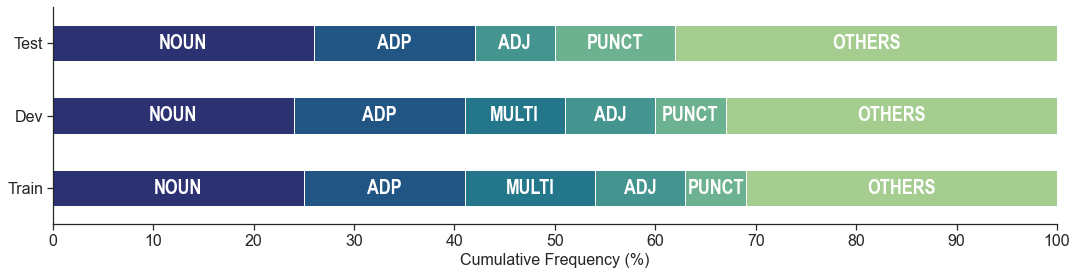

In [44]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s=row["Tag"], color="white", fontsize=20, fontstretch="condensed", 
                   fontweight="bold", horizontalalignment="center", verticalalignment="center")
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

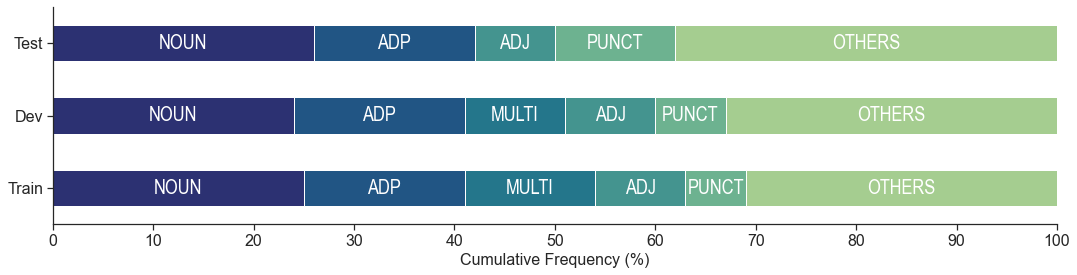

In [45]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s=row["Tag"], color="white", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center")
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

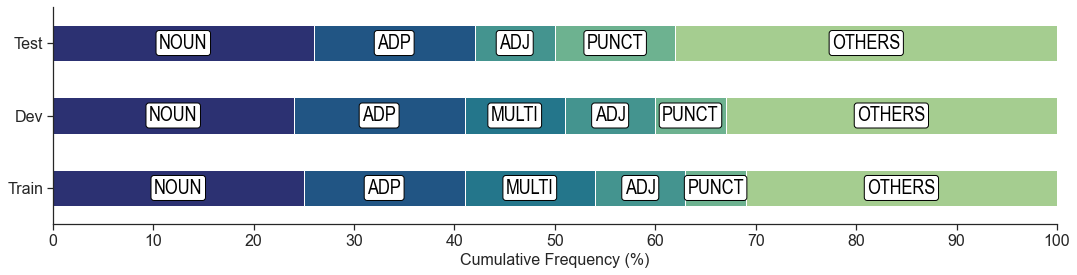

In [46]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s=row["Tag"], color="black", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", bbox=dict(boxstyle="round, pad=0.15",
                                                                                       fc="white", ec="black"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

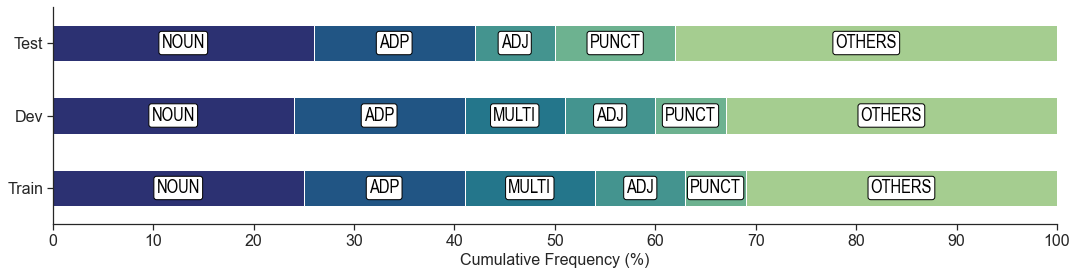

In [47]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s=row["Tag"], color="black", fontsize=18, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", bbox=dict(boxstyle="round, pad=0.15",
                                                                                       fc="white", ec="black"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

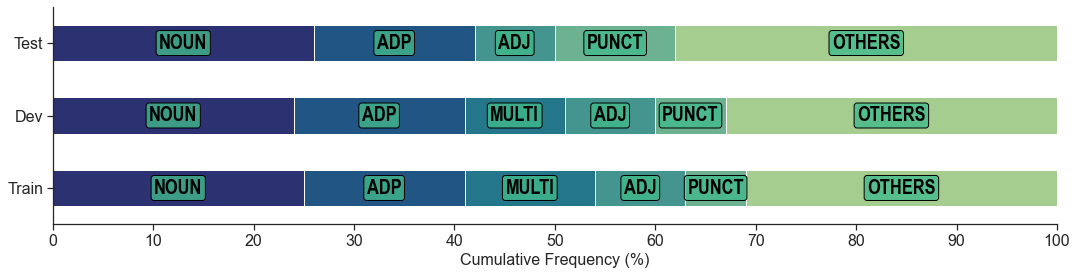

In [48]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s=row["Tag"], color="black", fontsize=20, fontstretch="condensed",
                   horizontalalignment="center", verticalalignment="center", fontweight="bold",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc=np.array([65, 186, 139, 200])/255,
                             ec="black"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

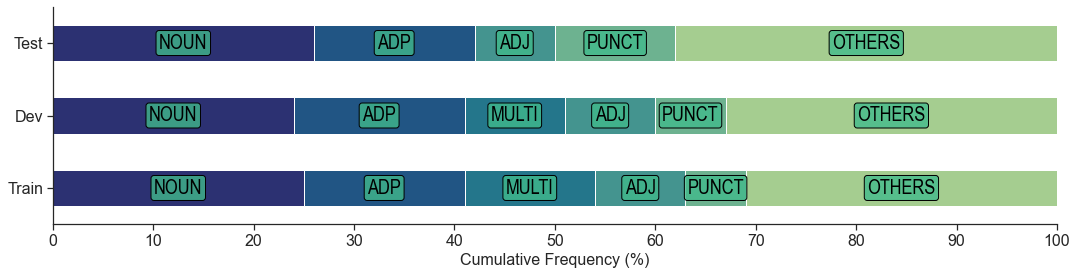

In [49]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s=row["Tag"], color="black", fontsize=20, fontstretch="condensed",
                   horizontalalignment="center", verticalalignment="center", fontweight="normal",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc=np.array([65, 186, 139, 200])/255,
                             ec="black"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

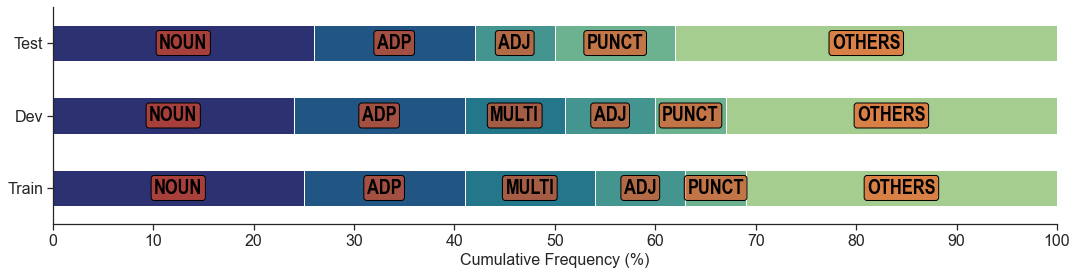

In [50]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s=row["Tag"], color="black", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="bold",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc=np.array([255, 75, 20, 150])/255,
                             ec="black"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

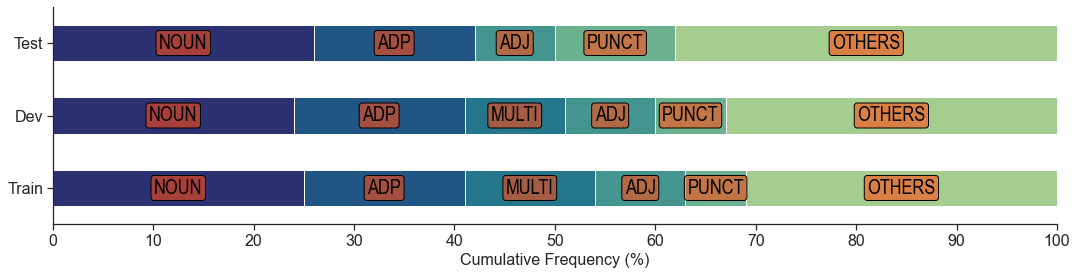

In [51]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s=row["Tag"], color="black", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc=np.array([255, 75, 20, 150])/255,
                             ec="black"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

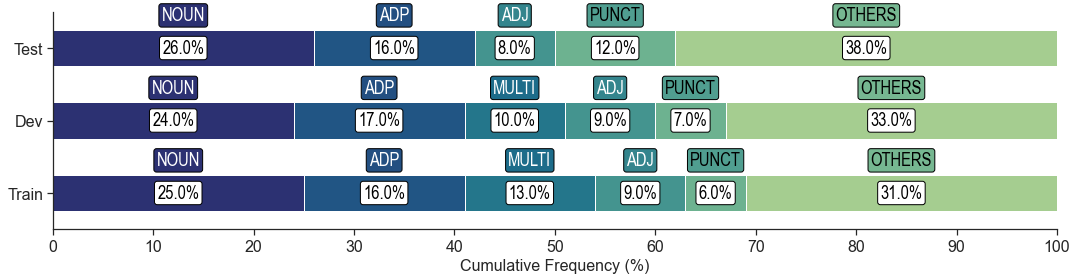

In [52]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
colors = ["#2c3172", "#234f81", "#1d6c8a", "#34858d", "#509e90", "#76b791", "#a5cd90"]
font_colors = ["white"] * 4 + ["black"] * 3
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y+0.45, s=row["Tag"], color=font_colors[i], fontsize=18, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc=colors[i],
                             ec="black"))
            g.text(x=x, y=y, s="{:.1f}%".format(current[y]), color="black", fontsize=18, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc="white",
                             ec="black"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

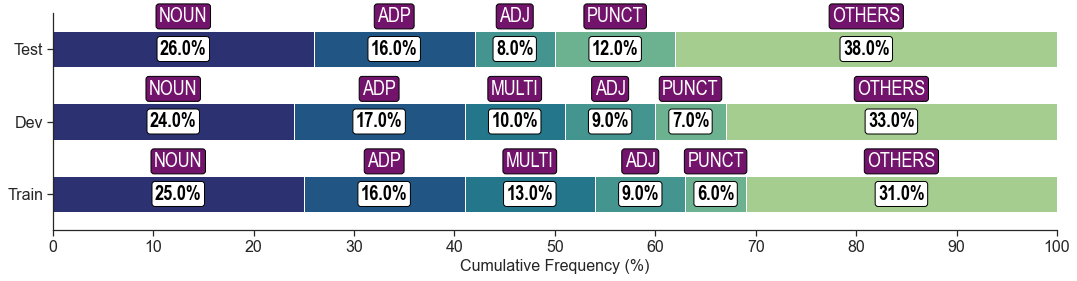

In [53]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y+0.45, s=row["Tag"], color="white", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc="#73146c",
                             ec="black"))
            g.text(x=x, y=y, s="{:.1f}%".format(current[y]), color="black", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="bold",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc="white",
                             ec="black"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

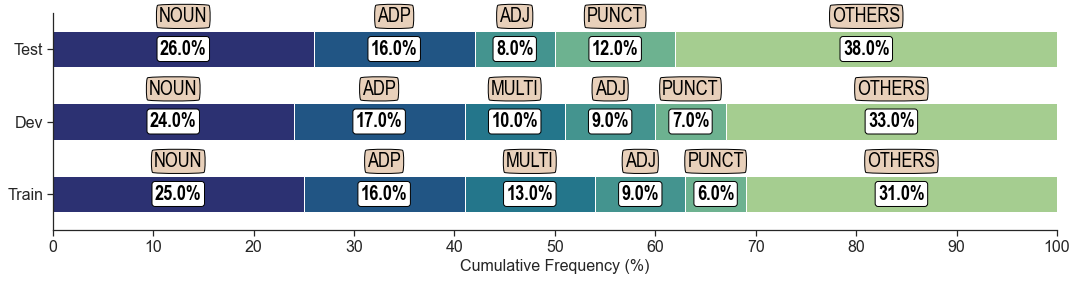

In [54]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y+0.45, s=row["Tag"], color="black", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal",
                   bbox=dict(boxstyle="round4, pad=0.15",
                             fc="#e8d0ba",
                             ec="black"))
            g.text(x=x, y=y, s="{:.1f}%".format(current[y]), color="black", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="bold",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc="white",
                             ec="black"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

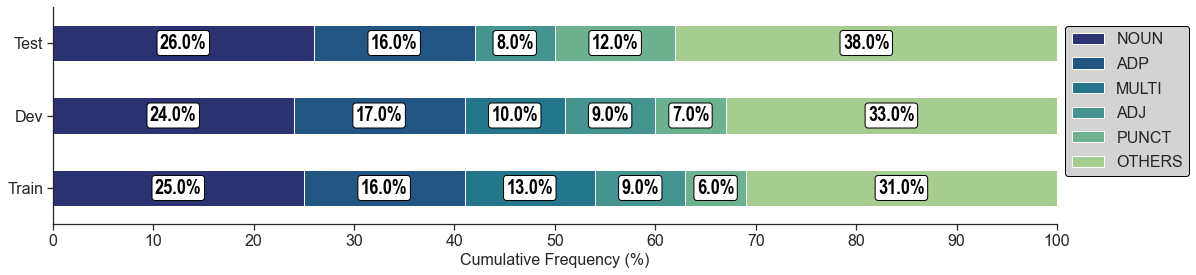

In [55]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s="{:.1f}%".format(current[y]), color="black", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="bold",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc="white",
                             ec="black"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(1, 0.95), fontsize=16, facecolor="lightgrey", 
         framealpha=1, edgecolor="black", labelspacing=0.6)
sns.despine(ax=g)

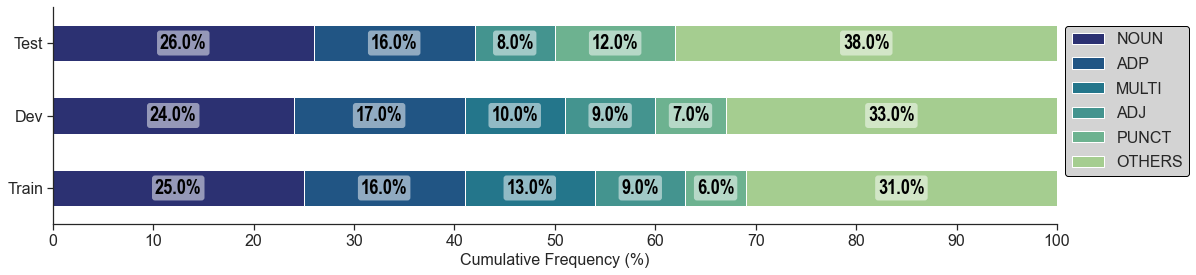

In [56]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s="{:.1f}%".format(current[y]), color="black", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="bold",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc=(1, 1, 1, 0.5),
                             ec="none"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(1, 0.95), fontsize=16, facecolor="lightgrey", 
         framealpha=1, edgecolor="black", labelspacing=0.6)
sns.despine(ax=g)

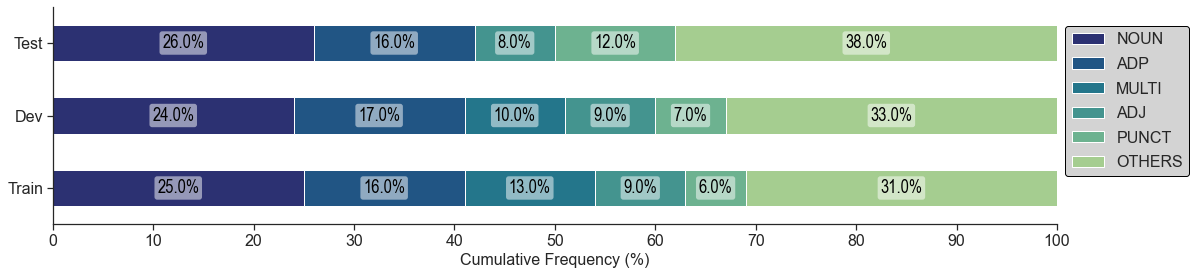

In [57]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s="{:.1f}%".format(current[y]), color="black", fontsize=18, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc=(1, 1, 1, 0.5),
                             ec="none"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(1, 0.95), fontsize=16, facecolor="lightgrey", 
         framealpha=1, edgecolor="black", labelspacing=0.6)
sns.despine(ax=g)

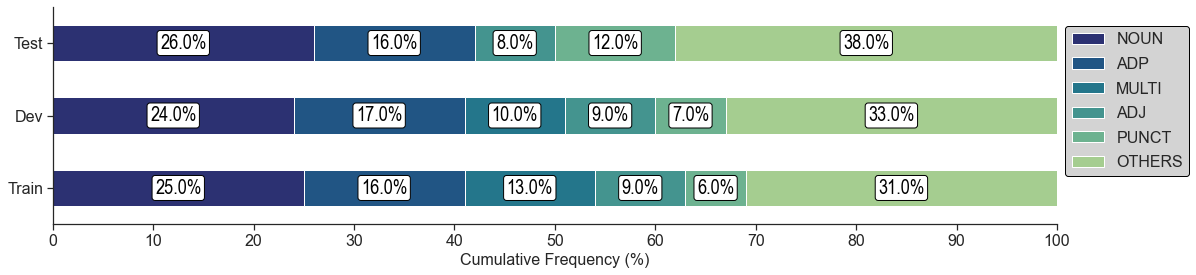

In [58]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s="{:.1f}%".format(current[y]), color="black", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc="white",
                             ec="black"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(1, 0.95), fontsize=16, facecolor="lightgrey", 
         framealpha=1, edgecolor="black", labelspacing=0.6)
sns.despine(ax=g)

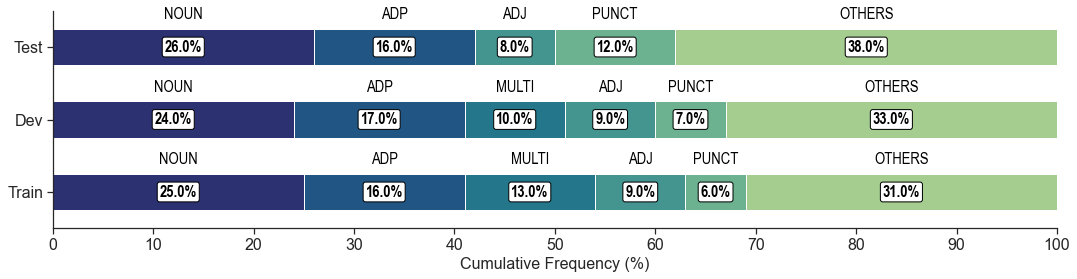

In [59]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y+0.45, s=row["Tag"], color="black", fontsize=16, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal")
            g.text(x=x, y=y, s="{:.1f}%".format(current[y]), color="black", fontsize=16, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="bold",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc="white",
                             ec="black"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

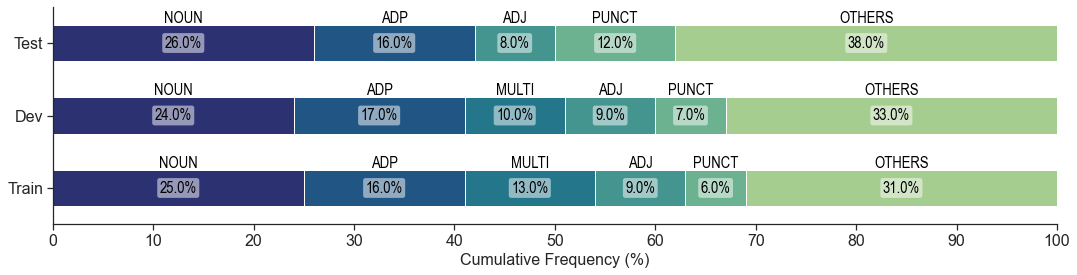

In [69]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y+0.35, s=row["Tag"], color="black", fontsize=16, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal")
            g.text(x=x, y=y, s="{:.1f}%".format(current[y]), color="black", fontsize=16, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc=(1, 1, 1, 0.5),
                             ec="none"))
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

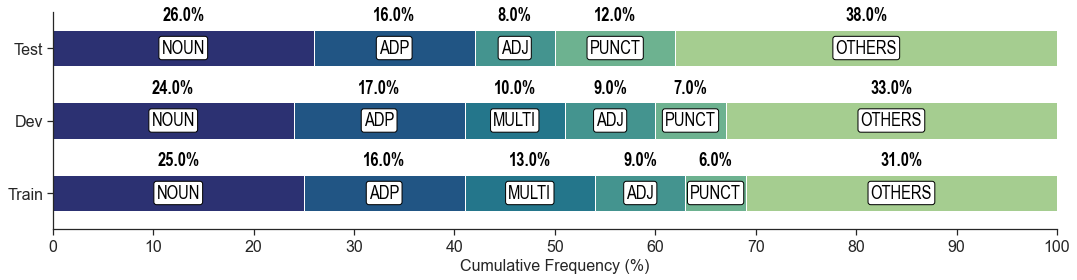

In [61]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s=row["Tag"], color="black", fontsize=18, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc="white",
                             ec="black"))
            g.text(x=x, y=y+0.45, s="{:.1f}%".format(current[y]), color="black", fontsize=18, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="bold")
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

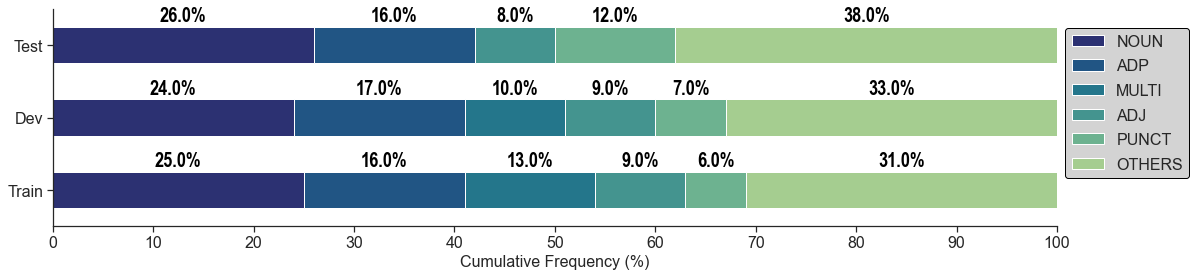

In [62]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, colormap="crest_r", figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y+0.4, s="{:.1f}%".format(current[y]), color="black", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="bold")
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(1, 0.95), fontsize=16, facecolor="lightgrey", 
         framealpha=1, edgecolor="black", labelspacing=0.6)
sns.despine(ax=g)

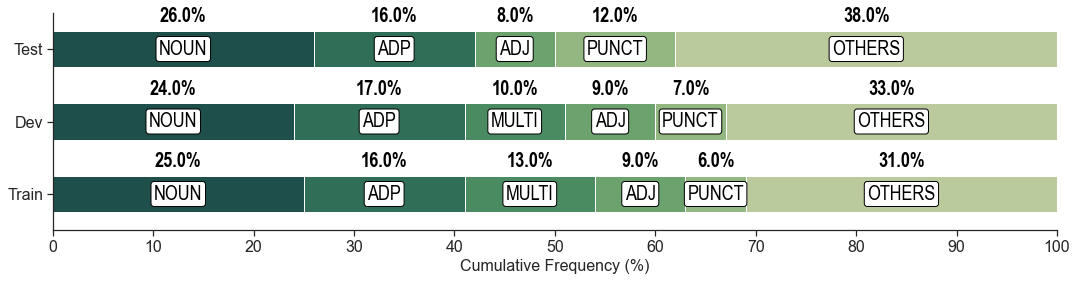

In [63]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="barh", stacked=True, 
                                    colormap=sns.cubehelix_palette(start=2.75, rot=-0.5, as_cmap=True, reverse=True,
                                                                   dark=0.25, light=.75), 
                                    figsize=(18,4), xlim=(0, 100))
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=x, y=y, s=row["Tag"], color="black", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc="white",
                             ec="black"))
            g.text(x=x, y=y+0.45, s="{:.1f}%".format(current[y]), color="black", fontsize=20, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="bold")
g.set_xticks(range(0, 101, 10))
g.set(xlabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(0.95, 0.95), fontsize=16).remove()
sns.despine(ax=g)

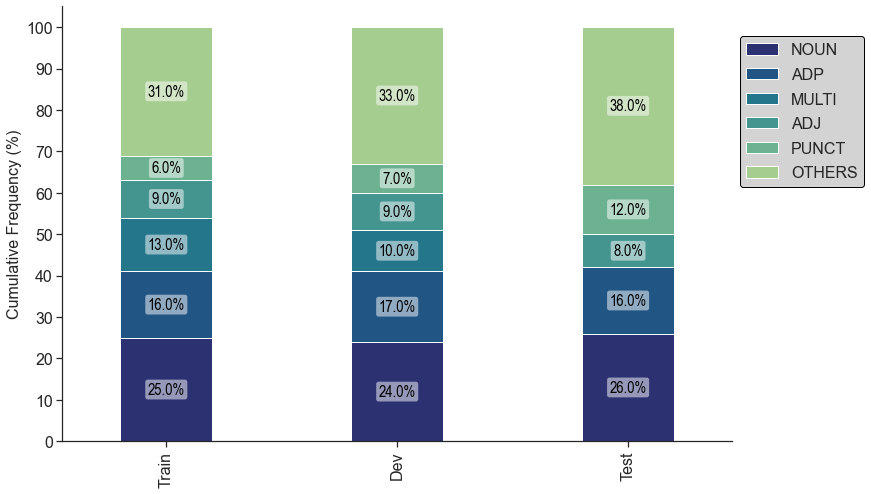

In [79]:
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc("axes", labelsize=16)
g = df_plot.set_index("Tag").T.plot(kind="bar", stacked=True, colormap="crest_r", figsize=(12,8), width=0.4)
for i, row in df_plot.iterrows():
    cumulative = df_plot.iloc[:i, 1:].sum().values
    current = df_plot.iloc[i, 1:].values
    for p, y in zip(row.iloc[1:], [0, 1, 2]):
        if row[y+1] != 0:
            x = cumulative[y] + current[y] / 2
            g.text(x=y, y=x, s="{:.1f}%".format(current[y]), color="black", fontsize=16, fontstretch="condensed", 
                   horizontalalignment="center", verticalalignment="center", fontweight="normal",
                   bbox=dict(boxstyle="round, pad=0.15",
                             fc=(1, 1, 1, 0.5),
                             ec="none"))
g.set_yticks(range(0, 101, 10))
g.set(ylabel = "Cumulative Frequency (%)")
g.legend(loc="upper left", bbox_to_anchor=(1, 0.95), fontsize=16, facecolor="lightgrey", 
         framealpha=1, edgecolor="black", labelspacing=0.6)
sns.despine(ax=g)